Dataset not found. Mounting Drive...
Mounted at /content/drive
Unzipping dataset...
Dataset ready ✅
['.config', 'knee-osteoarthritis-dataset-with-severity', 'drive', 'sample_data']
RUN_DIR: /content/experiments/resnet18_final_20260211_203556
Device: cuda
Classes: ['0', '1', '2', '3', '4']
Train/Val/Test: 5778 826 1656
Imbalance: WeightedRandomSampler ✅
Train class counts: [2286 1046 1516  757  173]
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


Loss: CrossEntropy ✅ (unweighted)
Training plan: 18 epochs (3 fc-only + 15 finetune)
[1/18] Stage1 | Train loss=1.5260 acc=0.3018 f1=0.2926 | Val loss=1.3731 acc=0.4262 f1=0.3239 | lr=1.00e-03
[2/18] Stage1 | Train loss=1.3960 acc=0.3814 f1=0.3702 | Val loss=1.3836 acc=0.3511 f1=0.3617 | lr=1.00e-03
[3/18] Stage1 | Train loss=1.3619 acc=0.3918 f1=0.3759 | Val loss=1.3657 acc=0.4056 f1=0.3584 | lr=1.00e-03
[4/18] Stage2 | Train loss=1.0585 acc=0.5296 f1=0.5238 | Val loss=1.0843 acc=0.5012 f1=0.5285 | lr=3.00e-04
[5/18] Stage2 | Train loss=0.8749 acc=0.6109 f1=0.6045 | Val loss=1.0158 acc=0.5726 f1=0.5422 | lr=3.00e-04
[6/18] Stage2 | Train loss=0.8129 acc=0.6296 f1=0.6241 | Val loss=1.0255 acc=0.5630 f1=0.5738 | lr=3.00e-04
[7/18] Stage2 | Train loss=0.7514 acc=0.6712 f1=0.6691 | Val loss=1.1009 acc=0.4770 f1=0.5387 | lr=3.00e-04
[8/18] Stage2 | Train loss=0.7627 acc=0.6533 f1=0.6543 | Val loss=0.9456 acc=0.5642 f1=0.5895 | lr=3.00e-04
[9/18] Stage2 | Train loss=0.7289 acc=0.6687 f1=0.6

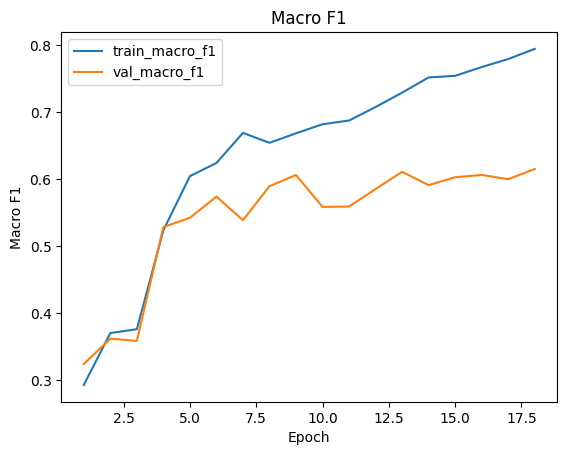

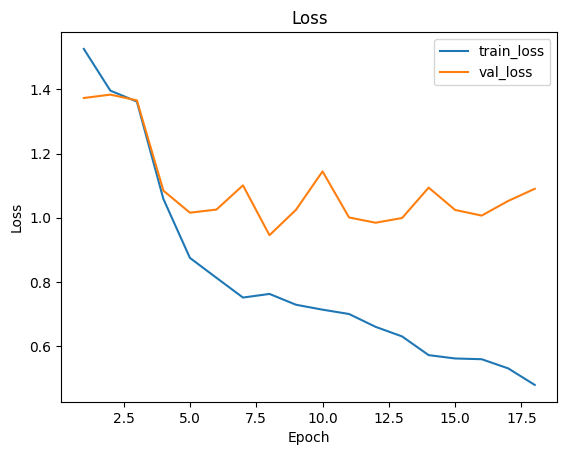


Done ✅


In [1]:
# =========================
# FINAL ResNet18 Baseline (Research-grade, configurable)

# AUTO DATASET LOADER + FINAL RESNET18 PIPELINE
# ============================================

import os

DATASET_NAME = "knee-osteoarthritis-dataset-with-severity"
ZIP_NAME = "knee_oa_dataset.zip"   # <-- make sure this matches your Drive file name

# 1️⃣ If dataset not found → mount drive + unzip
if not os.path.isdir(f"/content/{DATASET_NAME}"):
    print("Dataset not found. Mounting Drive...")
    from google.colab import drive
    drive.mount('/content/drive')

    zip_path = f"/content/drive/MyDrive/{ZIP_NAME}"
    if not os.path.isfile(zip_path):
        raise FileNotFoundError(f"ZIP file not found at {zip_path}")

    print("Unzipping dataset...")
    !unzip -q "{zip_path}" -d /content/

print("Dataset ready ✅")
print(os.listdir("/content"))



import os, time, json, random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler


# =========================
# 1) FLAGS (change only these)
# =========================
USE_SAMPLER = True          # True = WeightedRandomSampler, False = shuffle=True
USE_FOCAL_LOSS = False      # True = Focal Loss, False = CrossEntropyLoss
FOCAL_GAMMA = 2.0

IMAGE_SIZE = 224
BATCH_SIZE = 32

EPOCHS_STAGE1 = 3           # train only FC
EPOCHS_STAGE2 = 15          # finetune layer4 + FC

LR_STAGE1 = 1e-3
LR_STAGE2 = 3e-4
WEIGHT_DECAY = 1e-4

SEED = 42


# =========================
# 2) Reproducibility
# =========================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


# =========================
# 3) Paths
# =========================
DATA_DIR = "/content/knee-osteoarthritis-dataset-with-severity"
TRAIN_DIR = f"{DATA_DIR}/train"
VAL_DIR   = f"{DATA_DIR}/val"
TEST_DIR  = f"{DATA_DIR}/test"

assert os.path.isdir(TRAIN_DIR), f"Missing {TRAIN_DIR}"
assert os.path.isdir(VAL_DIR),   f"Missing {VAL_DIR}"
assert os.path.isdir(TEST_DIR),  f"Missing {TEST_DIR}"

RUN_NAME = time.strftime("resnet18_final_%Y%m%d_%H%M%S")
RUN_DIR = f"/content/experiments/{RUN_NAME}"
os.makedirs(f"{RUN_DIR}/checkpoints", exist_ok=True)
os.makedirs(f"{RUN_DIR}/logs", exist_ok=True)
os.makedirs(f"{RUN_DIR}/figures", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("RUN_DIR:", RUN_DIR)
print("Device:", device)


# =========================
# 4) Transforms
# =========================
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# =========================
# 5) Datasets
# =========================
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset   = datasets.ImageFolder(VAL_DIR,   transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(TEST_DIR,  transform=val_test_transforms)

NUM_CLASSES = len(train_dataset.classes)
print("Classes:", train_dataset.classes)
print("Train/Val/Test:", len(train_dataset), len(val_dataset), len(test_dataset))


# =========================
# 6) Dataloaders (Sampler OR Shuffle)
# =========================
if USE_SAMPLER:
    train_labels = np.array([y for _, y in train_dataset.samples])
    class_counts = np.bincount(train_labels, minlength=NUM_CLASSES)
    class_weights_np = 1.0 / (class_counts + 1e-6)
    sample_weights = class_weights_np[train_labels]
    sample_weights = torch.DoubleTensor(sample_weights)

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
    print("Imbalance: WeightedRandomSampler ✅")
    print("Train class counts:", class_counts)
else:
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    print("Imbalance: shuffle=True (NO sampler) ✅")

val_loader  = DataLoader(val_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


# =========================
# 7) Model
# =========================
def build_resnet18(num_classes: int):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = build_resnet18(NUM_CLASSES).to(device)

# Freeze everything first
for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True


# =========================
# 8) Loss
# =========================
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction="none")
        pt = torch.exp(-ce)
        loss = ((1 - pt) ** self.gamma) * ce
        return loss.mean()

if USE_FOCAL_LOSS:
    criterion = FocalLoss(gamma=FOCAL_GAMMA)
    print(f"Loss: FocalLoss ✅ (gamma={FOCAL_GAMMA})")
else:
    criterion = nn.CrossEntropyLoss()
    print("Loss: CrossEntropy ✅ (unweighted)")


# =========================
# 9) Train / Eval utilities
# =========================
def save_json(path, obj):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def run_one_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss = 0.0
    all_preds, all_targets = [], []

    for imgs, targets in loader:
        imgs, targets = imgs.to(device), targets.to(device)

        if is_train:
            optimizer.zero_grad()

        with torch.set_grad_enabled(is_train):
            outputs = model(imgs)
            loss = criterion(outputs, targets)
            if is_train:
                loss.backward()
                optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.detach().cpu().numpy().tolist())
        all_targets.extend(targets.detach().cpu().numpy().tolist())

    avg_loss = total_loss / len(loader.dataset)
    acc = accuracy_score(all_targets, all_preds)
    macro_f1 = f1_score(all_targets, all_preds, average="macro")
    return avg_loss, acc, macro_f1


# =========================
# 10) Training (Stage 1)
# =========================
history = []
best_val_f1 = -1.0
best_path = f"{RUN_DIR}/checkpoints/best_resnet18.pth"

TOTAL_EPOCHS = EPOCHS_STAGE1 + EPOCHS_STAGE2
print(f"Training plan: {TOTAL_EPOCHS} epochs ({EPOCHS_STAGE1} fc-only + {EPOCHS_STAGE2} finetune)")

optimizer = optim.Adam(model.fc.parameters(), lr=LR_STAGE1, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

for epoch in range(1, EPOCHS_STAGE1 + 1):
    train_loss, train_acc, train_f1 = run_one_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc, val_f1 = run_one_epoch(model, val_loader, optimizer=None)

    scheduler.step(val_f1)

    row = {
        "epoch": epoch,
        "stage": "fc_only",
        "train_loss": train_loss, "train_acc": train_acc, "train_macro_f1": train_f1,
        "val_loss": val_loss, "val_acc": val_acc, "val_macro_f1": val_f1,
        "lr": optimizer.param_groups[0]["lr"]
    }
    history.append(row)

    print(f"[{epoch}/{TOTAL_EPOCHS}] Stage1 | "
          f"Train loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} | "
          f"Val loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f} | lr={row['lr']:.2e}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_path)

save_json(f"{RUN_DIR}/logs/history_stage1.json", history)


# =========================
# 11) Training (Stage 2: finetune layer4 + fc)
# =========================
for name, param in model.named_parameters():
    if name.startswith("layer4") or name.startswith("fc"):
        param.requires_grad = True

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LR_STAGE2,
    weight_decay=WEIGHT_DECAY
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

for epoch in range(EPOCHS_STAGE1 + 1, TOTAL_EPOCHS + 1):
    train_loss, train_acc, train_f1 = run_one_epoch(model, train_loader, optimizer=optimizer)
    val_loss, val_acc, val_f1 = run_one_epoch(model, val_loader, optimizer=None)

    scheduler.step(val_f1)

    row = {
        "epoch": epoch,
        "stage": "finetune_layer4",
        "train_loss": train_loss, "train_acc": train_acc, "train_macro_f1": train_f1,
        "val_loss": val_loss, "val_acc": val_acc, "val_macro_f1": val_f1,
        "lr": optimizer.param_groups[0]["lr"]
    }
    history.append(row)

    print(f"[{epoch}/{TOTAL_EPOCHS}] Stage2 | "
          f"Train loss={train_loss:.4f} acc={train_acc:.4f} f1={train_f1:.4f} | "
          f"Val loss={val_loss:.4f} acc={val_acc:.4f} f1={val_f1:.4f} | lr={row['lr']:.2e}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), best_path)

save_json(f"{RUN_DIR}/logs/history_full.json", history)
print("Best val macro-F1:", best_val_f1)
print("Best checkpoint:", best_path)


# =========================
# 12) Test evaluation (best checkpoint)
# =========================
best_model = build_resnet18(NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for imgs, targets in test_loader:
        imgs, targets = imgs.to(device), targets.to(device)
        outputs = best_model(imgs)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_targets.extend(targets.cpu().numpy().tolist())

test_acc = accuracy_score(all_targets, all_preds)
test_macro_f1 = f1_score(all_targets, all_preds, average="macro")

print("\nTEST accuracy:", test_acc)
print("TEST macro-F1:", test_macro_f1)

print("\nClassification report:")
print(classification_report(all_targets, all_preds, target_names=train_dataset.classes, digits=4))

cm = confusion_matrix(all_targets, all_preds)
print("\nConfusion matrix:\n", cm)

metrics = {
    "use_sampler": USE_SAMPLER,
    "use_focal_loss": USE_FOCAL_LOSS,
    "focal_gamma": FOCAL_GAMMA if USE_FOCAL_LOSS else None,
    "best_val_macro_f1": float(best_val_f1),
    "test_accuracy": float(test_acc),
    "test_macro_f1": float(test_macro_f1),
}
save_json(f"{RUN_DIR}/logs/test_metrics.json", metrics)
print("\nSaved metrics to:", f"{RUN_DIR}/logs/test_metrics.json")


# =========================
# 13) Simple curves
# =========================
import pandas as pd
df = pd.DataFrame(history)
df.to_csv(f"{RUN_DIR}/logs/history.csv", index=False)

plt.figure()
plt.plot(df["epoch"], df["train_macro_f1"], label="train_macro_f1")
plt.plot(df["epoch"], df["val_macro_f1"], label="val_macro_f1")
plt.xlabel("Epoch"); plt.ylabel("Macro F1"); plt.legend(); plt.title("Macro F1"); plt.show()

plt.figure()
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.plot(df["epoch"], df["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss"); plt.show()

print("\nDone ✅")
